# Level 1 Requirement Flowdown Overview

## L1-1 Global Point Sources

> Carbon-I shall 

Let's codify these numbers

In [1]:
using Pkg
Pkg.activate("../.."); # Actives the environment at the root of the project
# Using our Carbon-I and vSmartMOM packages (developed by our team)
using CarbonI, vSmartMOM, Printf
using CairoMakie, DelimitedFiles, Statistics, Interpolations, NCDatasets, InstrumentOperator, LinearAlgebra
using Unitful, UnitfulEquivalences
include(joinpath("../../src/Plots", "CI_colorsNew.jl"));
include(joinpath(dirname(pathof(CarbonI)), "readSun.jl"))
include(joinpath(dirname(pathof(CarbonI)), "Requirements", "common.jl"))
using LaTeXStrings
set_theme!(theme_ggplot2())

  Activating project at `~/code/gitHub/CarbonI`
┌ Info: CUDA-enabled GPU(s) detected
└ @ vSmartMOM /home/cfranken/.julia/packages/vSmartMOM/a7WZC/src/vSmartMOM.jl:57
┌ Info: CUDA.CuDevice(0): NVIDIA A100-PCIE-40GB
└ @ vSmartMOM /home/cfranken/.julia/packages/vSmartMOM/a7WZC/src/vSmartMOM.jl:59
┌ Info: CUDA.CuDevice(1): NVIDIA A100-PCIE-40GB
└ @ vSmartMOM /home/cfranken/.julia/packages/vSmartMOM/a7WZC/src/vSmartMOM.jl:59


In [2]:
# Define numbers from L1 Requirements

# Flux limits:
flux_detect_ch4_req = 175.0u"kg/hr"    # in kg CH4/hr
flux_detect_co2_req = 100e3u"kg/hr"    # in kg CO2/hr
flux_detect_co_req  = 1.75e3u"kg/hr"   # in kg CO/hr

# GSD, required and CBE
gsd_req  = [400.0u"m", 400.0u"m"]      # in m
gsd_cbe  = [303.0u"m", 345.0u"m"]      # in m

2-element Vector{Quantity{Float64, 𝐋, Unitful.FreeUnits{(m,), 𝐋, nothing}}}:
 303.0 m
 345.0 m

In [3]:
# Effective Pixel Sizes
req_pix = sqrt(prod(gsd_req));
cbe_pix = sqrt(prod(gsd_cbe));

We can now derive the requirement for $\sigma_{s}$ for each trace gas, as:
$$
Q_{\min} = 
\underbrace{
\frac{M_{\mathrm{gas}}}{M_{\mathrm{DryAir}}}
\,\frac{\sigma_{\mathrm{gas}}\,p}{g}
}_{\sigma^*_{\mathrm{gas}}\ \mathrm{(amount/area)}}
\,\times\,
q\,U\,W, \tag{D-6}
$$

We can turn this into a requirement flowdown for the product of $\sigma_{\mathrm{gas}}$ and the GSD (W) for a fixed wind speed and q=2. Choosing our required GSD, we can solve for the required $\sigma_{\mathrm{gas}}$ to reach an actual $Q{\min}$ that is smaller than the requirement $Q^{req}_{\min}$:

$$
\sigma_{\mathrm{gas}}^{\mathrm{req}} \times W^{\mathrm{req}}  \le Q^{req}_{\min} \frac{1}{M_{\mathrm{gas}}} \underbrace{\frac{M_{\mathrm{DryAir}}\,g}{p}}_{\text{2.82 $\cdot$ 10$^{-6}$ m$^2$/mol}} \frac{1}{q\,U}
$$

In [4]:
# Define constants:
m = CarbonI.molar_mass()
C = CarbonI.Constants()
preFac = C.g * m.air / C.p

# q=2 for detection limits
q = 2.0
# Wind speed for the reference scenario
wind_speed = 2.0u"m/s"
# Value of the prefactor (a constant for a given surface pressure)
@show C.g * m.air / C.p

(C.g * m.air) / C.p = 2.841957e-6 m^2 mol^-1


2.841957e-6 m^2 mol^-1

In [5]:
σ_ch4_req = flux_detect_ch4_req * preFac / req_pix / m.ch4 / wind_speed / q
σ_co2_req = flux_detect_co2_req * preFac / req_pix / m.co2 / wind_speed / q
σ_co_req  = flux_detect_co_req  * preFac / req_pix / m.co  / wind_speed / q

@show uconvert(u"ppb", σ_ch4_req)
@show uconvert(u"ppm", σ_co2_req)
@show uconvert(u"ppb", σ_co_req)

@printf("Required Single Measurement Precision for CH₄ : %.3g ppb\n",  ustrip(uconvert(u"ppb", σ_ch4_req)))
@printf("Required Single Measurement Precision for CO₂ : %.3g ppm\n",  ustrip(uconvert(u"ppm", σ_co2_req)))
@printf("Required Single Measurement Precision for CO  : %.3g ppb\n",  ustrip(uconvert(u"ppb", σ_co_req)))

uconvert(u"ppb", σ_ch4_req) = 5.383053596477556 ppb
uconvert(u"ppm", σ_co2_req) = 1.1210981879118382 ppm
uconvert(u"ppb", σ_co_req) = 30.82619767493752 ppb
Required Single Measurement Precision for CH₄ : 5.38 ppb
Required Single Measurement Precision for CO₂ : 1.12 ppm
Required Single Measurement Precision for CO  : 30.8 ppb


In [6]:
# Use the reference scenario
scenario = CarbonI.reference_scenario();

# Load CBE specs
cbe_specs = CarbonI.build_instrument("CBE");

# Load Required specs
req_specs = CarbonI.build_instrument("Requirement");

(ds["T"])[iLon, iLat, :, timeIndex] = Union{Missing, Float32}[187.60953, 195.1012, 201.35501, 208.64655, 216.49673, 222.47076, 227.39767, 230.89746, 235.26309, 242.40393, 250.36801, 259.4926, 268.20334, 272.86224, 273.1006, 270.50668, 266.17313, 261.9602, 257.33777, 253.24066, 249.31465, 244.15125, 240.6859, 238.05463, 235.39015, 231.98767, 228.57484, 226.37009, 223.45546, 222.34386, 220.49219, 217.9867, 216.47473, 214.98712, 213.25296, 210.32483, 207.75937, 206.41586, 207.52103, 209.51251, 210.57042, 216.20634, 224.16565, 232.26859, 240.40128, 247.10199, 252.58617, 255.18288, 257.9303, 263.41864, 267.52917, 272.1396, 276.66675, 280.92175, 284.42505, 286.95496, 289.00113, 290.2957, 290.15128, 289.2277, 289.0184, 290.03265, 291.2717, 292.5702, 293.89865, 295.23, 296.56677, 297.8983, 299.22983, 300.5767, 301.94052, 303.46246]


In [7]:
# Create required Instrument model 
ins_req = InstrumentOperator.createGratingNoiseModel(req_specs.ET, req_specs.Pitch, 
		req_specs.FPA_quantum_efficiency, req_specs.bench_efficiency, 
		req_specs.Fnumber, 2*req_specs.SSI, 
		(req_specs.readout_noise), req_specs.dark_current); 

# Create required Instrument model
ins_cbe = InstrumentOperator.createGratingNoiseModel(cbe_specs.ET, cbe_specs.Pitch, 
		cbe_specs.FPA_quantum_efficiency, cbe_specs.bench_efficiency, 
		cbe_specs.Fnumber, 2*cbe_specs.SSI, 
		(cbe_specs.readout_noise), cbe_specs.dark_current); 

soil_req, x_req, solarIrr_req, σ_matrix_req, profile_req, h_req, Sₐ_req = setup_data(scenario, req_specs)
soil_cbe, x_cbe, solarIrr_cbe, σ_matrix_cbe, profile_cbe, h_cbe, Sₐ_cbe = setup_data(scenario, cbe_specs);

In [8]:
# Cumbersome to get to 0.15 here:
ll = length(req_specs.modelling_wl);
refl_req   = ones(ll) .* scenario.broadband_albedo;
refl_cbe   = ones(ll) .* scenario.broadband_albedo;

In [9]:
error_req, F_req = calc_rel_error(req_specs, x_req, solarIrr_req, refl_req, scenario.sza, σ_matrix_req, profile_req, h_req, ins_req, Sₐ_req, return_F=true) 
error_cbe, F_cbe = calc_rel_error(cbe_specs, x_cbe, solarIrr_cbe, refl_cbe, scenario.sza, σ_matrix_cbe, profile_cbe, h_cbe, ins_cbe, Sₐ_cbe, return_F=true) 

(Dict{Any, Any}("ch4" => 10.133360299653724, "h2o" => 25708.216256993277, "co" => 42.50982697820193, "n2o" => 19.695585686590995, "hdo" => 173818.85695104508, "c2h6" => 25.533314216261, "co2" => 2192.9966703142454, "co213" => 15567.326399293435), [2.9347659998209354, 2.9244170677547787, 2.7861478511231725, 2.458574551410483, 2.3708779581014725, 2.101959738259233, 1.5845150034998492, 1.8872018549331286, 2.487426918603361, 2.544563990075057  …  1.5793954880093588, 1.356428405620226, 0.9376469195457674, 0.8197518012739107, 0.7713671562665957, 0.7435625617427714, 0.689547995241922, 0.32934537134544783, 0.2291102579894721, 0.540061696871597])

In [10]:
sqrtN = sqrt(req_specs.coadd_rate)

3.1622776601683795

In [11]:
@printf("Expected Single Measurement Precision for CH₄ : %.3g ppb\n",  error_cbe["ch4"]/sqrtN)
@printf("Expected Single Measurement Precision for CO₂ : %.3g ppm\n",  error_cbe["co2"]/1000/sqrtN)
@printf("Expected Single Measurement Precision for CO  : %.3g ppb\n",  error_cbe["co"]/sqrtN)

Expected Single Measurement Precision for CH₄ : 3.2 ppb
Expected Single Measurement Precision for CO₂ : 0.693 ppm
Expected Single Measurement Precision for CO  : 13.4 ppb


In [12]:
# Now vary total efficiency at two different readout noise levels:

TotalEfficiencies = 0.2:0.05:1.0
gas_errors_100 = zeros(3,length(TotalEfficiencies))
gas_errors_120 = zeros(3,length(TotalEfficiencies))
for (i,efficiency) in enumerate(TotalEfficiencies)
    # Create instrument Specs here:
    # (here we need to use 57ms integration time for req. as we count 400m pixels along track dimension)
    ins_req_100 = InstrumentOperator.createGratingNoiseModel(57.0u"ms", req_specs.Pitch, 1.0, efficiency, req_specs.Fnumber, 2*req_specs.SSI, (100.0), req_specs.dark_current); 
    ins_req_120 = InstrumentOperator.createGratingNoiseModel(57.0u"ms", req_specs.Pitch, 1.0, efficiency, req_specs.Fnumber, 2*req_specs.SSI, (120.0), req_specs.dark_current); 
    # Create an error for 100 and 120e- for the respective efficiency
    error_varied_100 = calc_rel_error(req_specs, x_req, solarIrr_req, refl_req, scenario.sza, σ_matrix_req, profile_req, h_req, ins_req_100, Sₐ_req) 
    error_varied_120 = calc_rel_error(req_specs, x_req, solarIrr_req, refl_req, scenario.sza, σ_matrix_req, profile_req, h_req, ins_req_120, Sₐ_req) 
    # Store Data
    gas_errors_100[1,i] = error_varied_100["ch4"]/sqrt(req_specs.coadd_rate)
    gas_errors_120[1,i] = error_varied_120["ch4"]/sqrt(req_specs.coadd_rate) 
    gas_errors_100[2,i] = error_varied_100["co2"]/sqrt(req_specs.coadd_rate)
    gas_errors_120[2,i] = error_varied_120["co2"]/sqrt(req_specs.coadd_rate) 
    gas_errors_100[3,i] = error_varied_100["co"]/sqrt(req_specs.coadd_rate)
    gas_errors_120[3,i] = error_varied_120["co"]/sqrt(req_specs.coadd_rate) 
end

In [13]:
# Create an interpolation function to get the required optical efficiency for a given readout noise and proxy error for N2O
# Annoying as it requires ascending order in the x-axis
ch4_req_ppb = ustrip(uconvert(u"ppb", σ_ch4_req))
co2_req_ppb = ustrip(uconvert(u"ppb", σ_co2_req))
co_req_ppb  = ustrip(uconvert(u"ppb", σ_co_req))

efficiency_100_ch4 = LinearInterpolation(reverse(gas_errors_100[1,:]./ch4_req_ppb), reverse(TotalEfficiencies), extrapolation_bc=Line());
efficiency_120_ch4 = LinearInterpolation(reverse(gas_errors_120[1,:]./ch4_req_ppb), reverse(TotalEfficiencies), extrapolation_bc=Line());

efficiency_100_co2 = LinearInterpolation(reverse(gas_errors_100[2,:]./co2_req_ppb), reverse(TotalEfficiencies), extrapolation_bc=Line());
efficiency_120_co2 = LinearInterpolation(reverse(gas_errors_120[2,:]./co2_req_ppb), reverse(TotalEfficiencies), extrapolation_bc=Line());

efficiency_100_co = LinearInterpolation(reverse(gas_errors_100[3,:]./co_req_ppb), reverse(TotalEfficiencies), extrapolation_bc=Line());
efficiency_120_co = LinearInterpolation(reverse(gas_errors_120[3,:]./co_req_ppb), reverse(TotalEfficiencies), extrapolation_bc=Line());

In [14]:
all_curves = [efficiency_100_ch4, efficiency_120_ch4, efficiency_100_co2, efficiency_120_co2, efficiency_100_co, efficiency_120_co];
# Find driving requirement of all gases:
driving_req = maximum([eff(1.0) for eff in all_curves])

0.3292502604554097

In [15]:
# Define required efficiency for the driving requirement
req_eff     = driving_req;
# Required error ratio:
req_error       = 1.0;
# CBE efficiency 
eff_cbe = cbe_specs.bench_efficiency * cbe_specs.FPA_quantum_efficiency

0.57904

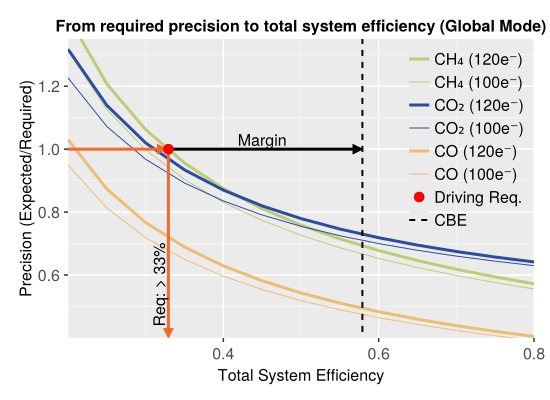

In [16]:
f = Figure(resolution=(550,400))
ax = Axis(f[1,1], xlabel="Total System Efficiency", ylabel="Precision (Expected/Required)",  title="From required precision to total system efficiency (Global Mode)")
# For CH4 (100 and 120e-)
lines!(ax, TotalEfficiencies, gas_errors_120[1,:]./ch4_req_ppb, color=CarbonI_colors[7], linewidth=3, label="CH₄ (120e⁻)")
lines!(ax, TotalEfficiencies, gas_errors_100[1,:]./ch4_req_ppb, color=CarbonI_colors[7], linewidth=1, label="CH₄ (100e⁻)")
# For CO2 (100 and 120e-)
lines!(ax, TotalEfficiencies, gas_errors_120[2,:]./co2_req_ppb, color=CarbonI_colors[4], linewidth=3, label="CO₂ (120e⁻)")
lines!(ax, TotalEfficiencies, gas_errors_100[2,:]./co2_req_ppb, color=CarbonI_colors[4], linewidth=1, label="CO₂ (100e⁻)")
# For CO (100 and 120e-)
lines!(ax, TotalEfficiencies, gas_errors_120[3,:]./co_req_ppb, color=CarbonI_colors[6], linewidth=3, label="CO (120e⁻)")
lines!(ax, TotalEfficiencies, gas_errors_100[3,:]./co_req_ppb, color=CarbonI_colors[6], linewidth=1, label="CO (100e⁻)")

# Lines for Driving Requirement
arrows!(ax, [0.0,],[1,],[req_eff-0.01,],[0,],arrowsize = 15, linewidth=3, color = CarbonI_colors[5])
arrows!(ax, [req_eff,],[req_error,],[0,],[-req_error+0.42,],arrowsize = 15, linewidth=3,color = CarbonI_colors[5])
text!(ax, "Req: > $(round(Int, 100req_eff))%", position = (req_eff, 0.57),
    align = (:center, :bottom), color = :black, rotation=π/2)

# Indicate Margins
arrows!(ax, [req_eff+0.002,],[req_error,],[eff_cbe-req_eff-0.01,],[0,],arrowsize = 15, linewidth=3, color = :black)
text!(ax, "Margin", position = (0.45, req_error),  align = (:center, :bottom), color = :black)
scatter!(ax, [req_eff], [req_error], color=:red, markersize=15, label="Driving Req.")
# Show CBE Total Efficiency
lines!(ax, [eff_cbe,eff_cbe], [0,1.35], color=:black, linestyle=:dash, linewidth=2, label="CBE")

xlims!(ax,0.2,0.8)
ylims!(ax,0.4,1.35)
axislegend(ax,position = :rt)
save("../../plots/final/Level1-1-EfficiencyDerivation_perGas.pdf",f)
f

In [17]:
# Going back full circle from CBE to expected L1 values
# For CH4
ch4_error_ppb = (error_cbe["ch4"]/sqrt(cbe_specs.coadd_rate))u"ppb"
flux_ch4_cbe_limit = uconvert(u"kg/hr", ch4_error_ppb * C.p /(C.g*m.air) * cbe_pix * m.ch4 * wind_speed * q )

# For CO2:
co2_error_ppb = (error_cbe["co2"]/sqrt(cbe_specs.coadd_rate))u"ppb"
flux_co2_cbe_limit = uconvert(u"kg/hr", co2_error_ppb * C.p /(C.g*m.air) * cbe_pix * m.co2 * wind_speed * q )

# For CO:
co_error_ppb = (error_cbe["co"]/sqrt(cbe_specs.coadd_rate))u"ppb"
flux_co_cbe_limit = uconvert(u"kg/hr", co_error_ppb * C.p /(C.g*m.air) * cbe_pix * m.co * wind_speed * q)

#@show uconvert(u"kg/hr", flux_ch4_cbe_limit)
# Computing CBE for L1-5:#
#proxy_error = error_cbe["n2o"]/background_vmr_n2o/sqrt(req_specs.coadd_rate)
#sigma_rel_cbe_agg = proxy_error / sqrt(N_eff_global_cbe)

@printf("CBE Flux Detection for CH₄ : %.3g kg/hr \n", ustrip(flux_ch4_cbe_limit)) 
@printf("CBE Flux Detection for CO₂ : %.3g kg/hr \n", ustrip(flux_co2_cbe_limit))
@printf("CBE Flux Detection for CO  : %.3g kg/hr",   ustrip(flux_co_cbe_limit))

CBE Flux Detection for CH₄ : 84.2 kg/hr 
CBE Flux Detection for CO₂ : 5e+04 kg/hr 
CBE Flux Detection for CO  : 617 kg/hr

### The End